In [1]:
# PYTHON PACKAGES USED
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import pandas as pd # module for data analysis
import geopandas as gpd # module for data analysis

In [499]:
# set up the geocoder
app = Nominatim(user_agent="JournalDev")

In [2]:
# get the source data as a dataframe
# df = pd.read_excel('../data/raw/Air Quality Analysis.xlsx', sheet_name='MAP LTN + Regular')
df = pd.read_excel('../data/interim/Air Quality Analysis.xlsx', sheet_name='MAP LTN + Regular')

In [605]:
# remove rows with NA values
df.dropna(inplace=True)

In [606]:
# check column names
df.columns
# note that the Location column name has a trailing space
# the Result column is presumably NO2 micrograms per cubic meter

Index(['Location ', 'Nominatim', 'Result'], dtype='object')

In [607]:
# strip trailing spaces from column names
df = df.rename(columns=lambda x: x.strip())

In [608]:
# remove both Bromley and newline character (stops Nominatim from working)
# df['Location'].replace(to_replace=['Bromley','\n.*'], value='', regex=True, inplace=True)
df['Nominatim'].replace(to_replace=['Bromley','\n.*'], value='', regex=True, inplace=True)

In [609]:
# remove street name after school (stops Nominatim from working)
# df['Location'].replace(to_replace='School,[^,]*,', value='School,', regex=True, inplace=True)
df['Nominatim'].replace(to_replace='School,[^,]*,', value='School,', regex=True, inplace=True)

In [610]:
df.head()

,Location,Nominatim,Result
0,"290 Brownhill Rd, London, SE6 1AU","290 Brownhill Rd, London, SE6 1AU",34.0
1,"baring road, london, se12","baring road, london, se12",33.4
2,"Bell Green, London,","Bell Green, London,",32.5
3,"montpelier vale, blackheath, london","montpelier vale, blackheath, london",31.2
4,"New Cross Rd, London, SE14 6AR","New Cross Rd, London, SE14 6AR",30.1


In [611]:
# function to geocode a location
def geocode_ltn(row):
    import time
    import numpy
    try:
        time.sleep(1)
        # location = app.geocode(row['Location'])
        location = app.geocode(row['Nominatim'])
        return [numpy.float64(location.raw['lon']), numpy.float64(location.raw['lat'])]
    except Exception as e:
        return None


In [612]:
# apply the function to the dataframe
df = pd.concat([df, df.apply(geocode_ltn, axis=1,result_type='expand')], axis=1)
# name the newly created long lat columns
df.rename(columns={0:"Longitude", 1:"Latitude"}, inplace=True)

In [660]:
# l = app.geocode('SE4 1YP')
# l.raw['lon']
df.loc[df['Nominatim'] == 'Montague Avenue, London, SE4', 'Longitude'] = l.raw['lon']
df.loc[df['Nominatim'] == 'Montague Avenue, London, SE4', 'Latitude'] = l.raw['lat']
df.loc[df['Nominatim'] == 'Montague Avenue, London, SE4']

,Location,Nominatim,Result,Longitude,Latitude,geometry
76,"Montague Avenue, London","Montague Avenue, London, SE4",19.4,-0.02905,51.46046,POINT (-0.02963 51.45968)


In [667]:
# look for non geocoded locations
df[df.Longitude.isna()]

,Location,Nominatim,Result,Longitude,Latitude,geometry


In [662]:
# output to csv
df.to_csv('../data/processed/ltn-plus-regular-sensors-geocoded.csv', index=False)

# create the spatial data frame

In [3]:
df = pd.read_csv('../data/processed/ltn-plus-regular-sensors-geocoded.csv')

In [4]:
# create a geometry series from the long lat columns
geometry = gpd.points_from_xy(df.Longitude, df.Latitude, crs="EPSG:4326")

In [5]:
# create a geo dataframe from the data + geometry series
gdf = gpd.GeoDataFrame(data=df, crs="EPSG:4326", geometry=geometry)

In [6]:
# remove the long lat columns (they are now in the geometry column)
gdf.drop(['Longitude', 'Latitude'], axis=1, inplace=True)

In [7]:
# check non geocoded locations
gdf[gdf.is_empty]

,Location,Nominatim,Result,geometry


In [8]:
# remove empty geometries and explore the data for baddly geocoded fields
gdf[~gdf.is_empty].explore()
# oh dear, there are some bad geocoded fields

In [9]:
# get lewisham geometry so we can remove points outside it
# lewisham = gpd.read_file('https://gist.githubusercontent.com/joe-liad/e66e2ec493ce3de692595b64eeb27b99/raw/bfaafeec350dfe4e5a20866a4660a188f8e6df7d/lewisham-wards.geojson')
lewisham = gpd.read_file('https://gist.github.com/joe-liad/436576eb30886ad488bf2c745576b3d1/raw/a352493ab6216deb9775d9c6c1cdac8afced087a/lewisham.geojson')

<AxesSubplot:>

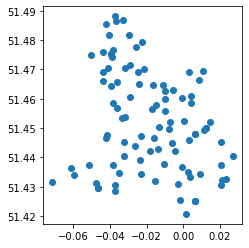

In [10]:
# check within
gdf[gdf.within(lewisham.geometry.unary_union)].plot()

In [11]:
# check not within
gdf[~gdf.within(lewisham.geometry.unary_union)]
# some are not within the lewisham wards, and some didn't geocode

,Location,Nominatim,Result,geometry
37,"Sparta Street, London","Sparta Street, London",23.6,POINT (-0.01487 51.47187)
54,1 Plough WayLondon SE16 2LS,"1 Plough Way, London, SE16 2LS",21.1,POINT (-0.04179 51.49241)
79,"19 Manor Road, Beckenham, BR3 5JB","19 Manor Road, London, BR3 5JB",19.2,POINT (-0.02300 51.40735)
91,"1 Woodville Close, London, SE3 8ED","1 Woodville Close, London, SE3 8ED",17.7,POINT (0.02580 51.47415)


In [12]:
# nullify the badly geocoded locations
from shapely.geometry import Point
for index, row in gdf[~gdf.within(lewisham.geometry.unary_union)].iterrows():
    gdf.loc[index, 'geometry'] = Point()

In [13]:
# check the rows without a location
gdf[gdf.is_empty]

,Location,Nominatim,Result,geometry
37,"Sparta Street, London","Sparta Street, London",23.6,GEOMETRYCOLLECTION EMPTY
54,1 Plough WayLondon SE16 2LS,"1 Plough Way, London, SE16 2LS",21.1,GEOMETRYCOLLECTION EMPTY
79,"19 Manor Road, Beckenham, BR3 5JB","19 Manor Road, London, BR3 5JB",19.2,GEOMETRYCOLLECTION EMPTY
91,"1 Woodville Close, London, SE3 8ED","1 Woodville Close, London, SE3 8ED",17.7,GEOMETRYCOLLECTION EMPTY


In [16]:
# look at the data
m = lewisham.append(gdf[gdf.within(lewisham.geometry.unary_union)]).explore(column="Result", legend=True, cmap='OrRd', style_kwds={'stroke':True, 'weight':2}, attr='Lewisham Insight & Delivery | Map tiles by <a href="http://stamen.com">Stamen</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> | Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors', legend_kwds={'caption': 'NO2 migrograms per cubic metre in 2020 - (target is below 40)'}, marker_kwds={'fill':True, 'radius': 5}, highlight=False, tooltip=['Location','Result'], tiles='Stamen Toner')
m.scrollWheelZoom=False,
m.save('../src/visualization/dist/index.html')
m

Text(0.1, 0.1, 'NO2 migrograms per cubic metre')

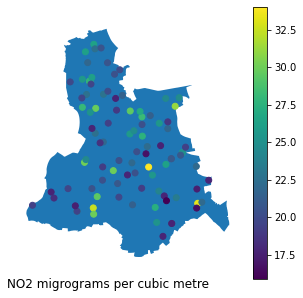

In [709]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
lewisham.plot(ax=ax)
gdf.plot(ax=ax, column="Result", legend=True).axis('off')
fig.text(.1,.1,'NO2 migrograms per cubic metre', fontsize=12)

In [719]:
# create GeoJSON
gdf.to_file('../data/processed/ltn-plus-regular-sensors-geocoded.geojson', driver='GeoJSON')
gdf.to_file('../src/visualization/dist/ltn-plus-regular-sensors-geocoded.geojson', driver='GeoJSON')

In [698]:
# how many rows
gdf.count()

Location     101
Nominatim    101
Result       101
geometry     101
dtype: int64

In [406]:
# how many rows without a location
gdf[gdf.is_empty].count()

Location    14
Result      14
geometry    14
dtype: int64

In [699]:
# look at empty locations
gdf[gdf.is_empty]

,Location,Nominatim,Result,geometry
37,"Sparta Street, London","Sparta Street, London",23.6,GEOMETRYCOLLECTION EMPTY
54,1 Plough WayLondon SE16 2LS,"1 Plough Way, London, SE16 2LS",21.1,GEOMETRYCOLLECTION EMPTY
79,"19 Manor Road, Beckenham, BR3 5JB","19 Manor Road, London, BR3 5JB",19.2,GEOMETRYCOLLECTION EMPTY
91,"1 Woodville Close, London, SE3 8ED","1 Woodville Close, London, SE3 8ED",17.7,GEOMETRYCOLLECTION EMPTY
